In [1]:
import sys
sys.path.append('../src')

from imports import *

def read_file(path):
    meta = pd.read_csv(path, index_col=False)
    return meta

c:\Users\tanve\Documents\Github\Dermoscopic-image-classification\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Training Adaboost with OpenML


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report

# Load the HAM10000 dataset
ham_data = fetch_openml(data_id=1687, as_frame=True)
X = ham_data.data.values
y = ham_data.target.values

# Preprocess the data (you can customize this based on your needs)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the base classifier (decision tree in this case)
base_classifier = DecisionTreeClassifier(max_depth=1)

# Initialize the AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)

# Train the AdaBoost classifier
adaboost_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = adaboost_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))



### Own Code 

In [3]:
csv_file = '../data/HAM10000_metadata.csv'
df = read_file(csv_file)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [4]:
df['img_path'] = "../data/HAM10000_images/"+df['image_id']+".jpg"
df.to_csv('../csv/all.csv', index=False)
df.head()

In [7]:
meta = df
X, y = meta.iloc[:,[0,1,3,4,5,6,7,8]], meta.iloc[:,2]

# train/test Split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, stratify=y)
print(f"train: {len(xtrain)}, test: {len(xtest)} ")

# Concat X/y for train/test
xtrain.insert(loc = 2, column = 'dx', value = ytrain)
xtest.insert(loc= 2 , column = 'dx', value = ytest )

# Writing to CSV
xtest.to_csv('../csv/test.csv', index=False)
xtrain.to_csv('../csv/train.csv', index=False)

xtrain['dx'].value_counts()

train: 8012, test: 2003 


dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64

In [8]:
train = read_file('../csv/train.csv')
majority = train[train['dx'] == 'nv']
minority = train[train['dx'] != 'nv']

majority.to_csv('../csv/train_majority.csv', index=False)
minority.to_csv('../csv/train_minority.csv', index=False)

In [4]:
train_minority = read_file('../csv/train_minority.csv')
train_minority.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,img_path
0,HAM_0000298,ISIC_0029051,bkl,histo,65.0,male,lower extremity,rosendahl,../data/HAM10000_images/ISIC_0029051.jpg
1,HAM_0000442,ISIC_0031565,mel,histo,45.0,male,foot,rosendahl,../data/HAM10000_images/ISIC_0031565.jpg
2,HAM_0005328,ISIC_0032441,mel,histo,75.0,male,abdomen,vidir_modern,../data/HAM10000_images/ISIC_0032441.jpg
3,HAM_0001796,ISIC_0029473,mel,histo,70.0,male,abdomen,vidir_modern,../data/HAM10000_images/ISIC_0029473.jpg
4,HAM_0004850,ISIC_0028126,mel,histo,30.0,female,trunk,vienna_dias,../data/HAM10000_images/ISIC_0028126.jpg


In [5]:
train_minority['dx'].value_counts()

dx
mel      890
bkl      879
bcc      411
akiec    262
vasc     114
df        92
Name: count, dtype: int64

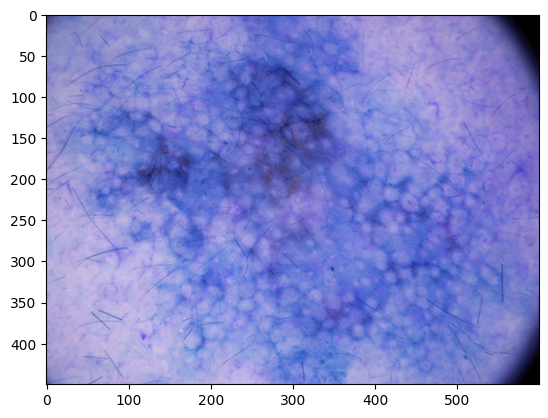

In [18]:
img = cv2.imread(train_minority['img_path'][random.randint(0, len(train_minority))])
plt.imshow(img)

In [6]:

# Sample size for each class
samples_per_class = 92

# Group the DataFrame by the 'class' column
grouped = train_minority.groupby('dx')

# Initialize an empty list to store the sampled data
sampled_data_list = []

# Loop through each group (class) and sample the specified number of rows
for _, group in grouped:
    if len(group) >= samples_per_class:
        sampled_data_list.append(group.sample(samples_per_class))
    else:
        sampled_data_list.append(group)

# Concatenate the sampled data into a single DataFrame
sampled_data = pd.concat(sampled_data_list, ignore_index=True)

# Now 'sampled_data' contains the desired number of samples from each class


# Now 'sampled_data' contains the desired number of samples from each class
sampled_data['dx'].value_counts()


dx
akiec    92
bcc      92
bkl      92
df       92
mel      92
vasc     92
Name: count, dtype: int64

In [36]:
sampled_data.to_csv('../csv/train_minority_92.csv', index=False)


In [2]:
sampled_data = read_file('../csv/train_minority_92.csv')
sampled_data.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,img_path
0,HAM_0005117,ISIC_0025712,akiec,histo,70.0,female,chest,rosendahl,../data/HAM10000_images/ISIC_0025712.jpg
1,HAM_0006482,ISIC_0027506,akiec,histo,55.0,female,hand,rosendahl,../data/HAM10000_images/ISIC_0027506.jpg
2,HAM_0002615,ISIC_0033494,akiec,histo,70.0,male,scalp,vidir_modern,../data/HAM10000_images/ISIC_0033494.jpg
3,HAM_0006213,ISIC_0025182,akiec,histo,60.0,female,hand,rosendahl,../data/HAM10000_images/ISIC_0025182.jpg
4,HAM_0004376,ISIC_0024843,akiec,histo,70.0,female,face,rosendahl,../data/HAM10000_images/ISIC_0024843.jpg


In [8]:
#  Validate the paths
def Check_Paths(file):
    meta = pd.read_csv(file)
    Files_NotFound = []
    for i, r in meta.iterrows():
        if os.path.exists(meta.iloc[i, -1]):
            continue
        else:
            Files_NotFound.append(meta.iloc[i, -1])
    return Files_NotFound

nf = Check_Paths('../csv/train_minority_92.csv')
len(nf) 

0

In [3]:
bkl = sampled_data[sampled_data['dx'] == 'bkl']
akiec = sampled_data[sampled_data['dx'] == 'akiec']
bcc = sampled_data[sampled_data['dx'] == 'bcc']
df = sampled_data[sampled_data['dx'] == 'df']
mel = sampled_data[sampled_data['dx'] == 'mel']
vasc = sampled_data[sampled_data['dx'] == 'vasc']



In [10]:
from PIL import Image
classes = ['bkl', 'akiec', 'bcc', 'df', 'mel', 'vasc']

os.makedirs('../data/Augmented/bkl_flip/', exist_ok=True)
save_dir = '../data/Augmented/'
for img in akiec['img_path']:
    image = Image.open(img)
    image =  image.transpose(Image.FLIP_LEFT_RIGHT)
    path = img.split('/')[-1].split('.')[0]
    image.save(f'../data/Augmented/bkl_flip/{path}_flip.jpg')


In [20]:
def Augment(dataframe, class_name, technique):
    os.makedirs(f'../data/Augmented/{class_name}_{technique}/', exist_ok=True)
    for img in dataframe['img_path']:
        image = Image.open(img)
        if technique == 'flip':
            image =  image.transpose(Image.FLIP_LEFT_RIGHT)
        elif technique == 'rotate':
            image = image.rotate(45)  # Rotate by 45 degrees
        elif technique == 'brightness':
            augmenter = transforms.ColorJitter(brightness=0.5)
            image = augmenter(image)
            
        path = img.split('/')[-1].split('.')[0]
        image.save(f'../data/Augmented/{class_name}_{technique}/{path}_{technique}.jpg')
    return "done"

In [21]:
Augment(bkl, 'bkl', 'flip')
Augment(akiec, 'akiec', 'flip')
Augment(bcc, 'bcc', 'flip')
Augment(df, 'df', 'flip')
Augment(mel, 'mel', 'flip')
Augment(vasc, 'vasc', 'flip')

Augment(bkl, 'bkl', 'rotate')
Augment(akiec, 'akiec', 'rotate')
Augment(bcc, 'bcc', 'rotate')
Augment(df, 'df', 'rotate')
Augment(mel, 'mel', 'rotate')
Augment(vasc, 'vasc', 'rotate')

Augment(bkl, 'bkl', 'brightness')
Augment(akiec, 'akiec', 'brightness')
Augment(bcc, 'bcc', 'brightness')
Augment(df, 'df', 'brightness')
Augment(mel, 'mel', 'brightness')
Augment(vasc, 'vasc', 'brightness')


'done'

In [ ]:
import shutil
os.makedirs('../data/Combined_minority/Flip_dataset', exist_ok=True)
os.makedirs('../data/Combined_minority/Rotate_dataset', exist_ok=True)
os.makedirs('../data/Combined_minority/Brightness_dataset', exist_ok=True)


for class_folder in os.listdir('../data/Augmented/'):
    print(f'Processing : {class_folder}')
    for image in os.listdir(f'../data/Augmented/{class_folder}'):
        shutil.copy(f'../data/Augmented/{class_folder}/{image}', f'../data/Combined_minority/{image}')
    print(f'\t \t Done..')


In [26]:
# Combining into Techinique type dataset folder
for image in os.listdir('../data/Combined_minority'):
    if image.split('_')[-1].split('.')[0] == 'flip':
        shutil.copy(f'../data/Combined_minority/{image}', f'../data/Combined_minority/Flip_dataset/{image}')
    elif image.split('_')[-1].split('.')[0] == 'rotate':
        shutil.copy(f'../data/Combined_minority/{image}', f'../data/Combined_minority/Rotate_dataset/{image}')
    elif image.split('_')[-1].split('.')[0] == 'brightness':
        shutil.copy(f'../data/Combined_minority/{image}', f'../data/Combined_minority/Brightness_dataset/{image}')

print(f'Done...')

Done...


In [1]:
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
train_flip = train_datagen.flow_from_directory('../data/Combined_minority/Flip_dataset', target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True)



In [ ]:
import pandas as pd
from PIL import Image
from torchvision import transforms  # You can use other augmentation libraries

# Load your DataFrame with 'dx' class labels and 'img_path' image paths
# df = ...

# Define augmentation techniques
augmentation_techniques = ['flip', 'rotate', 'brightness']

# Define the number of augmented samples per class per technique
augmented_samples_per_class = 5

# Initialize a list to store augmented data
augmented_data = []

# Loop through each class
for class_label in df['dx'].unique():
    class_samples = df[df['dx'] == class_label]
    
    # Loop through each augmentation technique
    for technique in augmentation_techniques:
        for index, sample in class_samples.iterrows():
            img_path = sample['img_path']
            img = Image.open(img_path)
            
            # Apply the selected augmentation technique
            if technique == 'flip':
                augmented_img = img.transpose(Image.FLIP_LEFT_RIGHT)
            elif technique == 'rotate':
                augmented_img = img.rotate(45)  # Rotate by 45 degrees
            elif technique == 'brightness':
                augmenter = transforms.ColorJitter(brightness=0.5)
                augmented_img = augmenter(img)
            
            # Append the augmented sample to the list
            augmented_data.append({
                'dx': class_label,
                'img_path': None,  # Store the new image path if needed
                'augmentation_technique': technique,
                'augmented_image': augmented_img
            })

# Create a new DataFrame from the augmented data
augmented_df = pd.DataFrame(augmented_data)

# You can save the augmented images to disk if needed
for idx, row in augmented_df.iterrows():
    image_filename = f"augmented_{row['dx']}_{row['augmentation_technique']}_{idx}.jpg"
    row['augmented_image'].save(image_filename)

# Now 'augmented_df' contains the augmented data

    

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Simulated augmentation techniques
augmentation_techniques = ['flip', 'rotate', 'crop', 'brightness']

# Simulated augmented datasets
augmented_datasets = {
    'flip': X_flip_augmented,
    'rotate': X_rotate_augmented,
    'crop': X_crop_augmented,
    'brightness': X_brightness_augmented
}

# Initialize a dictionary to store weak learners' performance
weak_learners_performance = {}

# Train weak learners and evaluate them
for technique in augmentation_techniques:
    X_augmented = augmented_datasets[technique]
    y_augmented = y_original  # Assuming the labels remain the same
    
    weak_classifier = DecisionTreeClassifier(max_depth=1)
    weak_classifier.fit(X_augmented, y_augmented)
    
    y_pred = weak_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    weak_learners_performance[technique] = accuracy

# Calculate weights based on performance
weights = {technique: accuracy for technique, accuracy in weak_learners_performance.items()}

# Normalize weights
sum_weights = sum(weights.values())
normalized_weights = {technique: weight / sum_weights for technique, weight in weights.items()}

# Aggregate predictions using weighted averaging
ensemble_prediction = np.zeros_like(y_test)
for technique, weight in normalized_weights.items():
    weak_classifier = DecisionTreeClassifier(max_depth=1)
    weak_classifier.fit(augmented_datasets[technique], y_original)
    ensemble_prediction += weight * weak_classifier.predict(X_test)

# Final prediction is based on the aggregated ensemble_prediction
final_prediction = np.round(ensemble_prediction)

# Evaluate the final prediction
ensemble_accuracy = accuracy_score(y_test, final_prediction)
print(f"Ensemble Accuracy: {ensemble_accuracy:.2f}")


### Fresh Start

In [2]:
import sys
sys.path.append('../src')

from imports import *

def read_file(path):
    meta = pd.read_csv(path, index_col=False)
    return meta

c:\Users\tanve\Documents\Github\Dermoscopic-image-classification\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

dataframe = read_file('../csv/train_minority_92.csv')
y = dataframe['dx']
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
train = train_datagen.flow_from_dataframe(dataframe, x_col='img_path', y_col='dx', target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True)

base_classifier = DecisionTreeClassifier(max_depth=1)
n_estimators = 50  # You can adjust this as needed
adaboost_classifier = AdaBoostClassifier(base_estimator=base_classifier, n_estimators=n_estimators)


Found 552 validated image filenames belonging to 6 classes.


In [8]:
adaboost_classifier.fit(train, y)

KeyboardInterrupt: 

In [3]:
import os
path = '../data/Augmented/'
os.listdir(path)

['akiec_brightness',
 'akiec_flip',
 'akiec_rotate',
 'bcc_brightness',
 'bcc_flip',
 'bcc_rotate',
 'bkl_brightness',
 'bkl_flip',
 'bkl_rotate',
 'df_brightness',
 'df_flip',
 'df_rotate',
 'mel_brightness',
 'mel_flip',
 'mel_rotate',
 'vasc_brightness',
 'vasc_flip',
 'vasc_rotate']

In [14]:
import pandas as pd
df = pd.DataFrame(columns=['img_path', 'dx'])
for class_folder in os.listdir(path):
    if class_folder.split('_')[-1] == 'flip':
        for image in os.listdir(f'{path}{class_folder}'):
            df.loc[len(df)] = [f'{path}{class_folder}/{image}', class_folder.split('_')[0]]
df.head()
df.to_csv('../data/Augmented/flip.csv', index=False)

In [13]:
del df